# A simple engine for image searching: A SimilaritySearch.jl tutorial
by: Eric S. Téllez


## Installing packages
As usual, the first step consists on initializing the environment

In [1]:
using Pkg
pkg"activate ."
# pkg"add Printf MLDatasets LinearAlgebra Images StatsBase StatsPlots https://github.com/sadit/SimilaritySearch.jl"
using Printf, MLDatasets, MLDataUtils, LinearAlgebra, Images, ImageIO, StatsBase, StatsPlots, Statistics, SimilaritySearch


  Activating environment at `~/Research/SimilaritySearchExamples/classification/Project.toml`


## Loading benchmarks
Here we use the [Fashion-MNIST](https://juliaml.github.io/MLDatasets.jl/latest/datasets/FashionMNIST/) dataset (loaded with MLDatasets) which is designed to be a drop-in replacement for the well known MNIST.

In [2]:
function load_data()
    train_X, train_y = FashionMNIST.traindata()
    test_X, test_y = FashionMNIST.testdata()
    
    #train_X, train_y = MNIST.traindata()
    #test_X, test_y = MNIST.testdata()
    (train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)
end

D = load_data()
size(D.train_X), size(D.test_X), typeof(D.train_X)

((28, 28, 60000), (28, 28, 10000), Base.ReinterpretArray{N0f8, 3, UInt8, Array{UInt8, 3}, false})

## About preparing the data
While `SimilaritySearch.jl` works with several data types, we decide to convert data instead of writing a new distance function
to handle each image; also, it provides some speedup and reduces overflow problems on direct computation over the `MLDatasets.jl`'s numeric encoding for _MNIST_ and _Fashion-MNIST_.

In [3]:

vec(X, i) = Float32.(reshape(view(X, :, :, i), 28 * 28))

#vec(X, i) = Float32.(reshape(view(X, :, :, i), 28 * 28)) |> normalize!
#dist = angle_distance

X = [vec(D.train_X, i) for i in 1:60000]
queries = [vec(D.test_X, i) for i in 1:10000]
eltype(X)

Vector{Float32} (alias for Array{Float32, 1})

## Visualizing
The following functions will display images in the notebook

In [4]:
display_one(m) = display(Gray.(reshape(m, 28, 28))')
display_many(arr) = display(Gray.(hcat([reshape(m, 28, 28)' for m in arr]...)))


display_many (generic function with 1 method)

## Searching demos

The first demo is made with an exhaustive search; this algorithm is pretty simple but low performant; it is indicated whenever the construction time can't be amortized by the number of queries.

┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1313


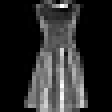

results (obj => dist): 21710 => 11.67, 20199 => 14.96, 4814 => 15.53, 57955 => 15.87, 52140 => 16.17, 8578 => 16.24, 18411 => 16.26, 14013 => 16.49, 30216 => 16.97, 48997 => 17.00, 59615 => 17.21, 32 => 17.39, 43815 => 17.50, 53625 => 17.74, 51177 => 17.79

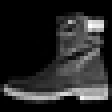

  0.084106 seconds (75.97 k allocations: 4.253 MiB, 74.83% compilation time)


results (obj => dist): 26118 => 18.03, 27434 => 18.39, 4803 => 19.35, 50124 => 19.60, 52998 => 19.73, 2015 => 20.43, 25051 => 20.74, 15560 => 20.84, 6068 => 21.18, 1337 => 21.85, 10523 => 22.27, 30995 => 22.63, 43684 => 22.75, 23468 => 23.82, 31792 => 24.97

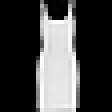

results (obj => dist): 16460 => 3.76, 54158 => 7.47, 58600 => 8.06, 56416 => 8.19, 39495 => 9.71, 8451 => 10.91, 29205 => 11.09, 21191 => 11.33, 40358 => 11.39, 52963 => 11.54, 56468 => 11.92, 57109 => 12.24, 1998 => 12.62, 5423 => 12.88, 5961 => 12.94

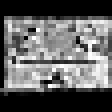

results (obj => dist): 14230 => 37.25, 34875 => 38.75, 22536 => 38.93, 12506 => 39.01, 6433 => 39.02, 7606 => 39.02, 36064 => 39.79, 20261 => 39.84, 45896 => 41.11, 36279 => 41.28, 27746 => 41.38, 55503 => 41.73, 5118 => 41.76, 13760 => 41.89, 36819 => 42.61

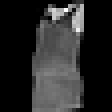

results (obj => dist): 1072 => 12.99, 53213 => 13.97, 39516 => 14.40, 3 => 14.53, 27328 => 14.92, 18698 => 15.61, 35364 => 15.67, 20377 => 15.98, 25520 => 16.26, 56484 => 16.37, 27254 => 16.39, 38601 => 16.52, 45413 => 16.58, 57614 => 16.76, 6130 => 16.80

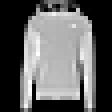

results (obj => dist): 9492 => 10.77, 5483 => 11.57, 13920 => 12.06, 35798 => 12.14, 31914 => 12.47, 11599 => 13.89, 6961 => 13.95, 33318 => 14.29, 20255 => 14.35, 33319 => 14.51, 34788 => 14.67, 58750 => 14.82, 47211 => 16.20, 56319 => 16.24, 30296 => 16.44

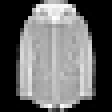

  0.020508 seconds
  0.020469 seconds
  0.020492 seconds
  0.020393 seconds
  0.020284 seconds


results (obj => dist): 51515 => 11.22, 32094 => 12.79, 27676 => 13.29, 52103 => 14.19, 43938 => 15.58, 59323 => 15.83, 59782 => 15.99, 2639 => 15.99, 29856 => 16.03, 53732 => 16.10, 58477 => 16.23, 34890 => 16.54, 46556 => 16.75, 47718 => 16.81, 31099 => 17.19

  0.020471 seconds


In [5]:

function sequential_search_demo()
    index = ExhaustiveSearch(SqL2Distance(), X)

    for q in rand(queries, 7)
        display_one(q)
        @time res = search(index, q, 15)
        display_many([X[p.id] for p in res])
        msg = [(@sprintf "%d => %0.2f" p.id p.dist) for p in res]
        display("text/html", "results (obj => dist): " * join(msg, ", "))
    end
    
    index
end

seq = sequential_search_demo();

## Searching with faster indexes
Fast exact indexes can be created using metric division strategies, but the faster ones some times are designed to retrieve an approximation of the solution. In any case, indexes for fast similarity search need to amortize the construction cost with a large number of queries. The following functions only exemplify the searching process, however, the number of queries is too small to show the typical case of use of these indexes.


## Solving queries with a proximity search graph
The `SearchGraph` is a faster index but with a more expensive construction.

{SearchGraph: dist=SqL2Distance(), n=0, search_algo={BeamSearch: bsize=16, ssize=16, hints=0, neighborhood_algo=LogNeighborhood, knn=10}
added n=10000, neighborhood=14, {BeamSearch: bsize=16, ssize=16, hints=0, LogNeighborhood, 2021-02-11T10:40:30.157
added n=20000, neighborhood=15, {BeamSearch: bsize=16, ssize=16, hints=0, LogNeighborhood, 2021-02-11T10:40:33.652
added n=30000, neighborhood=15, {BeamSearch: bsize=16, ssize=16, hints=0, LogNeighborhood, 2021-02-11T10:40:38.298
added n=40000, neighborhood=16, {BeamSearch: bsize=16, ssize=16, hints=0, LogNeighborhood, 2021-02-11T10:40:43.821
added n=50000, neighborhood=16, {BeamSearch: bsize=16, ssize=16, hints=0, LogNeighborhood, 2021-02-11T10:40:50.072
added n=60000, neighborhood=16, {BeamSearch: bsize=16, ssize=16, hints=0, LogNeighborhood, 2021-02-11T10:40:56.959

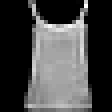

results (obj => dist): 8653 => 14.52, 7471 => 18.06, 46018 => 18.42, 49643 => 18.55, 53696 => 20.29, 44775 => 20.42, 56368 => 22.61, 38489 => 23.31, 2961 => 23.62, 40288 => 24.11, 32686 => 24.13, 55137 => 24.17, 42165 => 24.60, 30343 => 24.64, 233 => 24.78

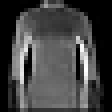

results (obj => dist): 40840 => 21.90, 50922 => 22.06, 11887 => 22.40, 55863 => 22.54, 34026 => 22.61, 23958 => 23.10, 6850 => 23.18, 41632 => 23.27, 38936 => 23.42, 45654 => 23.47, 36444 => 23.59, 34916 => 23.76, 43698 => 24.13, 3362 => 24.61, 22203 => 24.95

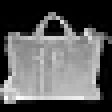

results (obj => dist): 56069 => 25.31, 18568 => 29.10, 26036 => 29.36, 37831 => 31.99, 23482 => 36.23, 14297 => 37.45, 18735 => 38.85, 58458 => 38.86, 48750 => 39.54, 8539 => 39.56, 2697 => 41.29, 23860 => 42.70, 1011 => 42.74, 47752 => 43.07, 18109 => 43.20

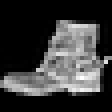

results (obj => dist): 35453 => 18.46, 46974 => 18.90, 47693 => 20.45, 51945 => 20.47, 7103 => 21.43, 58322 => 21.54, 13791 => 22.88, 42045 => 23.00, 51099 => 23.38, 34021 => 23.39, 31293 => 23.55, 50182 => 23.87, 30774 => 23.88, 44378 => 24.42, 42285 => 24.58

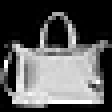

results (obj => dist): 26387 => 28.49, 3453 => 30.84, 27076 => 36.69, 25935 => 37.12, 12629 => 38.44, 50843 => 39.55, 35168 => 41.05, 2987 => 41.40, 18502 => 41.42, 36697 => 42.31, 25114 => 42.51, 19284 => 42.74, 35303 => 42.79, 15625 => 43.18, 11099 => 43.36

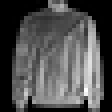

results (obj => dist): 19326 => 20.28, 7765 => 20.46, 1246 => 20.92, 58040 => 20.94, 24144 => 21.60, 25850 => 21.76, 40908 => 22.33, 52269 => 22.53, 9286 => 22.73, 11517 => 22.93, 6623 => 23.13, 25527 => 23.27, 55343 => 23.40, 17119 => 23.47, 53048 => 23.49

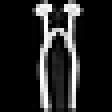

results (obj => dist): 59789 => 39.88, 22607 => 40.02, 59911 => 40.26, 3345 => 40.59, 38422 => 41.42, 47872 => 41.49, 26701 => 42.34, 14164 => 42.60, 22910 => 42.75, 33074 => 42.75, 8433 => 43.12, 38948 => 43.18, 28332 => 43.36, 28939 => 43.61, 56526 => 43.73

 29.891469 seconds (1.58 M allocations: 107.024 MiB, 4.86% compilation time)
  0.000211 seconds
  0.000624 seconds
  0.000443 seconds
  0.000379 seconds
  0.000648 seconds
  0.000508 seconds
  0.000649 seconds


In [6]:
function searchgraph_search_demo()
    # a real index only works whenever the number of queries amortizes the construction cost
    @time index = SearchGraph(SqL2Distance(), X, verbose=true)
    for q in rand(queries, 7)
        display_one(q)
        @time res = search(index, q, 15)
        display_many([X[p.id] for p in res])
        msg = [(@sprintf "%d => %0.2f" p.id p.dist) for p in res]
        display("text/html", "results (obj => dist): " * join(msg, ", "))
    end
    
    index
end

sgraph = searchgraph_search_demo();

## A simple NN classifier
Lets create a classifier to measure the performance and the quality impact of the different indexes

In [7]:
function classify(index, train_y, queries, test_y)
    ypred = []
    for i in eachindex(queries)
        res = search(index, queries[i], 1)
        push!(ypred, train_y[first(res).id])
    end
    
    println("NN-classifier $(typeof(index)) accuracy:", mean(ypred .== test_y))
end


classify (generic function with 1 method)

In [8]:
@time classify(seq, D.train_y, queries, D.test_y)
@time classify(sgraph, D.train_y, queries, D.test_y)

NN-classifier ExhaustiveSearch{SqL2Distance, Vector{Vector{Float32}}} accuracy:0.8497
200.937413 seconds (1.28 M allocations: 73.774 MiB, 0.06% gc time, 0.27% compilation time)
NN-classifier SearchGraph{SqL2Distance, Vector{Vector{Float32}}, BeamSearch, LogNeighborhood} accuracy:0.8026
  3.354777 seconds (48.24 k allocations: 2.643 MiB, 1.06% compilation time)
